<a href="https://colab.research.google.com/github/Rajatkhatri7/LeNet5-Fashion/blob/master/LeNet_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using LeNet CNN
## Fashion MNIST Dataset - Clothing Objects (10 classes)
### t-shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot

![fashionMNIST Sample Data](images/fashionMNISTExamples.png)

In [1]:
# import tensorflow module. Check API version.
import tensorflow as tf
import numpy as np

print (tf.__version__)

# required for TF to run within docker using GPU (ignore otherwise)
# gpu = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], True)

2.3.0


## Load the data

In [2]:
# grab the Fashion MNIST dataset (may take time the first time)
print("[INFO] downloading Fashion MNIST...")
(trainData, trainLabels), (testData, testLabels) = tf.keras.datasets.fashion_mnist.load_data()

[INFO] downloading Fashion MNIST...
4423680/4422102 [==============================] - 0s 0us/step


## Prepare the data

In [3]:
print(trainData.shape)
print(testData.shape)


(60000, 28, 28)
(10000, 28, 28)


In [4]:
# parameters for Fashion MNIST data set
num_classes = 10
image_width = 28
image_height = 28
image_channels = 1
# define human readable class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat/jacket',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
# shape the input data using "channels last" ordering
# num_samples x rows x columns x depth
trainData = trainData.reshape(
        (trainData.shape[0], image_height, image_width, image_channels))
testData = testData.reshape(
        (testData.shape[0], image_height, image_width, image_channels))

In [6]:
# convert to floating point and scale data to the range of [0.0, 1.0]
trainData = trainData.astype("float32") / 255.0
testData = testData.astype("float32") / 255.0

In [7]:
# pad the data to 32X32 for use in LeNet5 network
trainData = np.pad(trainData, ((0,0),(2,2),(2,2),(0,0)), 'constant')
testData = np.pad(testData, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [8]:
# display data dimentions
print ("trainData:", trainData.shape)
print ("trainLabels:", trainLabels.shape)
print ("testData:", testData.shape)
print ("testLabels:", testLabels.shape)

trainData: (60000, 32, 32, 1)
trainLabels: (60000,)
testData: (10000, 32, 32, 1)
testLabels: (10000,)


In [9]:
# parameters for training data set
num_classes = 10
image_width = 32
image_height = 32
image_channels = 1

## Define Model

![LeNet5 Model](images/LeNet5.jpg)

In [39]:
# import the necessary packages
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers

# define the model as a class
class LeNet:
    # INPUT => CONV => TANH => AVG-POOL => CONV => TANH => AVG-POOL => FC => TANH => FC => TANH => FC => SMAX
    @staticmethod
    def init(numChannels, imgRows, imgCols, numClasses, weightsPath=None):
        # if we are using "channels first", update the input shape
        if backend.image_data_format() == "channels_first":
            inputShape = (numChannels, imgRows, imgCols)
        else:  # "channels last"
            inputShape = (imgRows, imgCols, numChannels)

        # initialize the model
        model = models.Sequential()

        # define the first set of CONV => ACTIVATION => POOL layers
        model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1),
                padding="valid", activation=tf.nn.tanh, input_shape=inputShape))
        model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

        # define the second set of CONV => ACTIVATION => POOL layers
        model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1),
                padding="valid", activation=tf.nn.tanh))
        model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

        # flatten the convolution volume to fully connected layers
        model.add(layers.Flatten())

        # define the first FC => ACTIVATION layers
        model.add(layers.Dense(units=120, activation=tf.nn.tanh))

        # define the second FC => ACTIVATION layers
        model.add(layers.Dense(units=84, activation=tf.nn.tanh))

        # lastly, define the soft-max classifier
        model.add(layers.Dense(units=numClasses, activation=tf.nn.softmax))

        # if a weights path is supplied (inicating that the model was
        # pre-trained), then load the weights
        if weightsPath is not None:
            model.load_weights(weightsPath)

        # return the constructed network architecture
        return model

## Compile Model

In [40]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.init(numChannels=image_channels,
                    imgRows=image_height, imgCols=image_width,
                    numClasses=num_classes,
                    weightsPath=None)

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.05),  # Stochastic Gradient Descent
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])

# print model summary
model.summary()

[INFO] compiling model...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_20 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_21 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_31 (Dense)           

## Train Model

In [41]:
# define callback function for training termination criteria
#accuracy_cutoff = 0.99
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(logs.get('accuracy') > 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
# initialize training config
batch_size = 128
epochs = 120

# run training
print("[INFO] training...")
history = model.fit(x=trainData, y=trainLabels, validation_data=(testData, testLabels),batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[myCallback()])

[INFO] training...
Epoch 1/120
469/469 [==============================] - 2s 4ms/step - loss: 0.7883 - accuracy: 0.7223 - val_loss: 0.6043 - val_accuracy: 0.7791
Epoch 2/120
469/469 [==============================] - 2s 3ms/step - loss: 0.5214 - accuracy: 0.8107 - val_loss: 0.5044 - val_accuracy: 0.8123
Epoch 3/120
469/469 [==============================] - 1s 3ms/step - loss: 0.4547 - accuracy: 0.8359 - val_loss: 0.4687 - val_accuracy: 0.8252
Epoch 4/120
469/469 [==============================] - 1s 3ms/step - loss: 0.4197 - accuracy: 0.8487 - val_loss: 0.4291 - val_accuracy: 0.8437
Epoch 5/120
469/469 [==============================] - 1s 3ms/step - loss: 0.3928 - accuracy: 0.8586 - val_loss: 0.4228 - val_accuracy: 0.8465
Epoch 6/120
469/469 [==============================] - 2s 3ms/step - loss: 0.3744 - accuracy: 0.8651 - val_loss: 0.3933 - val_accuracy: 0.8572
Epoch 7/120
469/469 [==============================] - 1s 3ms/step - loss: 0.3604 - accuracy: 0.8695 - val_loss: 0.4014 - v

## Evaluate Training Performance

### Expected Output

![accplot](images/accuracyLeNetFashionMNIST2.png) ![lossplot](images/lossLeNetFashionMNIST2.png)

Text(0.5, 1.0, 'Training and validation loss')

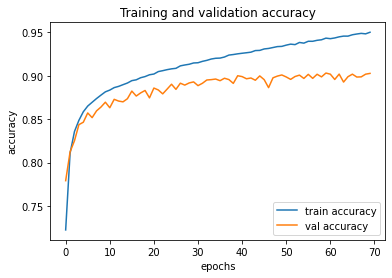

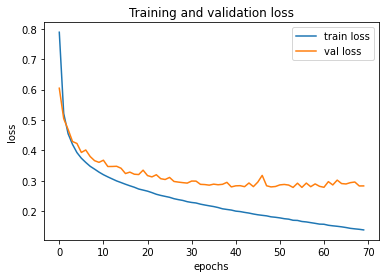

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

# retrieve a list of list results on training and test data sets for each training epoch
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # get number of epochs

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="lower right")
plt.title('Training and validation accuracy')
plt.figure()

# plot training and validation loss per epoch
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [43]:
# show the accuracy on the testing set
print("[INFO] evaluating...")
(loss, accuracy) = model.evaluate(testData, testLabels,
                                  batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

[INFO] evaluating...
79/79 [==============================] - 0s 3ms/step - loss: 0.2833 - accuracy: 0.9028
[INFO] accuracy: 90.28%


In [44]:
model.save_weights("LeNetFashionMNIST.temp.hdf5", overwrite=True)

## Evaluate Pre-trained Model

In [45]:
# init model and load the model weights
print("[INFO] compiling model...")
model = LeNet.init(numChannels=image_channels, 
                    imgRows=image_height, imgCols=image_width,
                    numClasses=num_classes,
                    weightsPath="/content/LeNetFashionMNIST.temp.hdf5")

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),  # Stochastic Gradient Descent
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])

[INFO] compiling model...


In [46]:
# show the accuracy on the testing set
print("[INFO] evaluating...")
batch_size = 128
(loss, accuracy) = model.evaluate(testData, testLabels,
                                  batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

[INFO] evaluating...
79/79 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.9028
[INFO] accuracy: 90.28%


## Model Predictions

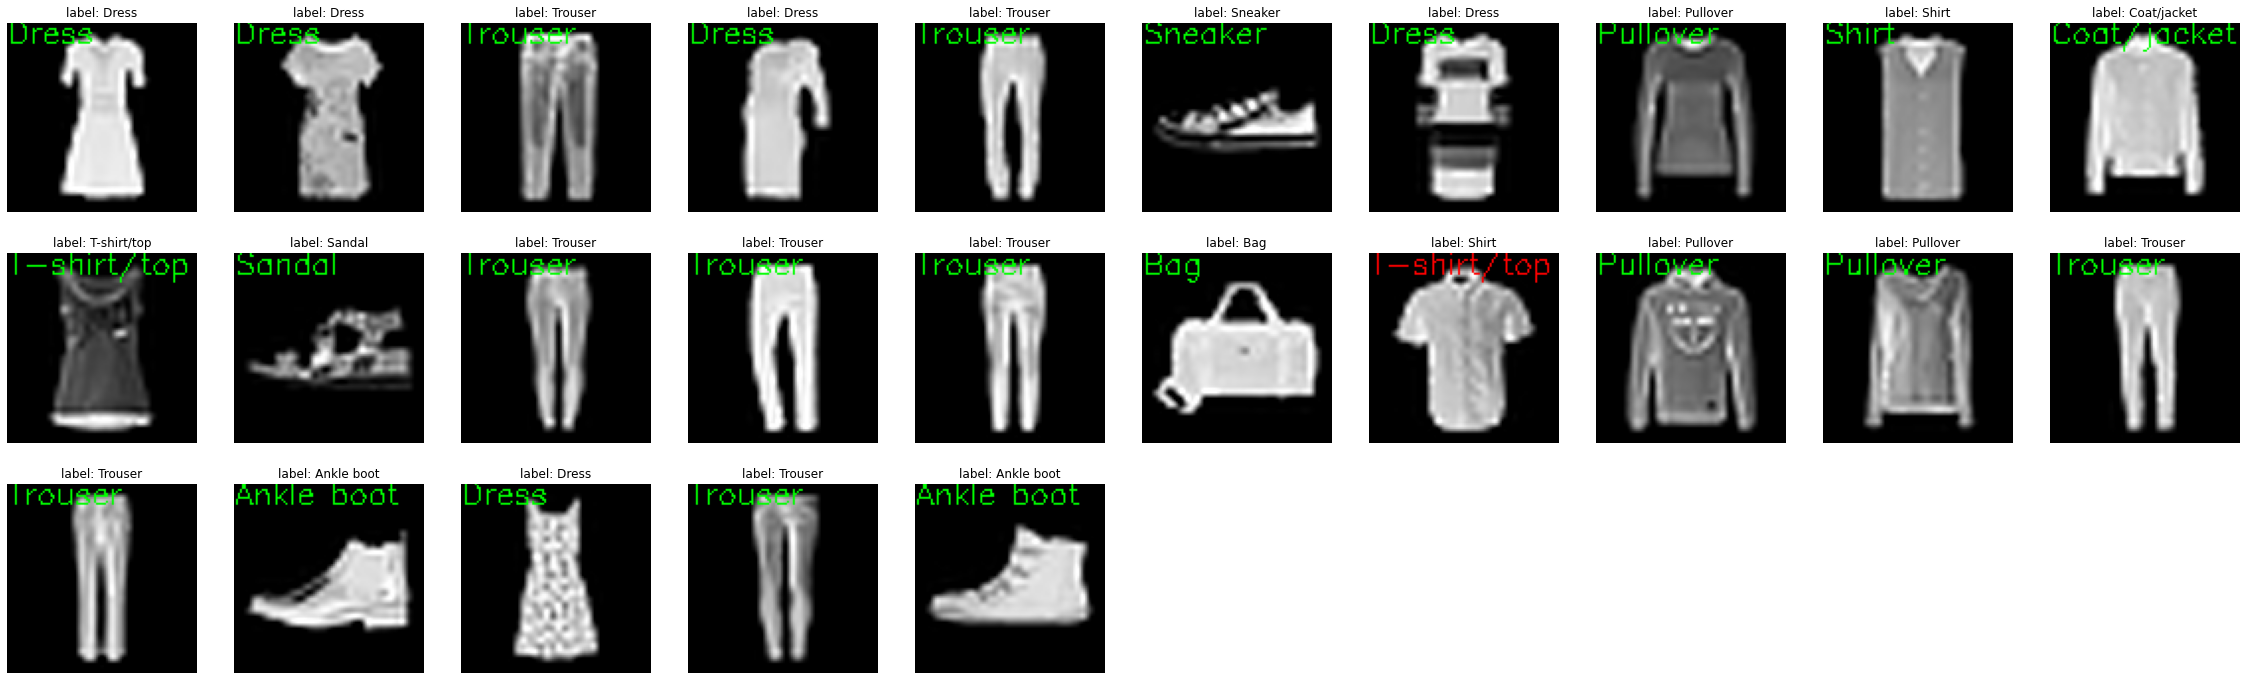

In [51]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

# set up matplotlib fig, and size it to fit 3x4 pics
nrows = 3
ncols = 10
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# randomly select a few testing digits
num_predictions = 25
test_indices = np.random.choice(np.arange(0, len(testLabels)), size=(num_predictions,))
test_images = np.stack(([testData[i] for i in test_indices]))
test_labels = np.stack(([testLabels[i] for i in test_indices]))

# compute predictions
predictions = model.predict(test_images)

for i in range(num_predictions):
    # select the most probable class
    prediction = np.argmax(predictions[i])

    # rescale the test image
    image = (test_images[i] * 255).astype("uint8")

    # resize the image from a 28 x 28 image to a 96 x 96 image so we can better see it
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_CUBIC)

    # convert grayscale image to RGB color
    image = cv2.merge([image] * 3)

    # select prediction text color
    if prediction == test_labels[i]:
        rgb_color = (0, 255, 0) # green for correct predictions
    else:
        rgb_color = (255, 0, 0) # red for wrong predictions

    # show the image and prediction
    cv2.putText(image, str(class_names[prediction]), (0, 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, rgb_color, 1)
    
    # set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1, title="label: %s" % class_names[test_labels[i]])
    sp.axis('Off') # don't show axes (or gridlines)
    plt.imshow(image)

# show figure matrix
plt.show()